### RNN (Recurrent Neural Network)

순환 신경망(RNN = Recurrent Neural Network)은 시퀀스(연속된 데이터)를 다루기 위해 설계된 인공 신경망의 한 종류이다. 일반적으로 다층 퍼셉트론(Multi-layer Perceptron, MLP)이나 CNN은 입력 간의 시간적 순서를 고려하지 않는다. 반면, RNN은 이전 입력에서의 정보를 메모리(state) 형태로 유지해서, 과거의 정보가 현재 출력에 영향을 줄 수 있게 만든다.

그래서 순서가 중요한 데이터를 처리하는 데 탁월하다. 예를 들어, 문장 번역 (자연어 처리), 음성 인식, 주식 시계열 예측, 날씨 예측

**구조**
1. 입력 시퀀스
2. 은닉 상태(Hidden State)
3. 출력 (Output)

일반적인 인공 신경망은 입력 -> 출력으로 끝나는 구조이다. 하지만 RNN은 이전 단계에서의 정보를 다음 단계로 넘겨주는 구조를 가지고 있다. 마치 연결된 사슬 처럼 작동한다.

입력이 들어온다. -> RNN은 입력을 처리하고 기억(hidden state)에 저장한다. -> 다음 입력을 받을 떄, 이전의 기억을 함꼐 활용해서 처리한다.

이 과정을 매번 반복해서 시간의 흐름에 따라 순차적으로 데이터를 다룬다.

**은닉 상태**
RNN의 핵심은 은닉 상태(hidden state) 라는 기억 장치이다.
* 첫 입력이 들어오면, 새로운 기억을 만다.
* 두 번째 입력이 들어오면, 첫 번째 기억과 함께 처리한다.
* 계속 그렇게 이어지기 때문에, 과거의 흐름을 이해할 수 있다.

하지만 과거가 멀어질수록 잊어버리기 쉽다는 단점도 있다.

이를 개선하기 위해 LSTM, GRU 등도 나왔다. 이를 이용하면 긴 문장과 긴 시계열도 처리 할 수 있다.

|모델 이름|특징|
|-|-|
LSTM(Long Short-Term Memory)| 중요한 정보는 오래 기억하고, 불필요한 건 잊도록 설계
GRU(Gated Recurrent Unit) | LSTM보다 가볍고 계산량이 적으면서도 성능이 좋다.

```python
import torch.nn as nn

rnn = nn.RNN(input_size=10, hidden_size=20, batch_first=True)
```

* input_size : 들어오는 데이터의 크기
* hidden_size : RNN이 내부적으로 기억하는 크기
* batch_first=True : 데이터를 배치, 시퀀스, 특성 순서로 준다.



In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import trange

### 1. 데이터 불러오기

In [15]:
df = pd.read_csv("./data/kospi.csv")

In [16]:
df.head() # 기본적으로 5개의 행을 보여준다.

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [17]:
scaler = MinMaxScaler()
# 모든 값을 0과 1 사이로 스케일링 한다.
df[["Open", "High", "Low", "Close", "Volume"]] = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Volume"]])

In [18]:
df.head() # 스케일링된 데이터 확인

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


2. 텐서 데이터 만들기

In [20]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f'{device} is available')

mps is available


In [21]:
# Dataset
X = df[['Open', 'High', 'Low', 'Volume']].values # 시가, 고가, 저가, 거래량 -> 예측에 도움이 되는 특징값(feature)들
Y = df[['Close']].values # 종가 -> 예측하고자 하는 값(target)

print(X)
print(Y)

[[0.72289794 0.73235114 0.74552494 0.24211269]
 [0.76305769 0.75006898 0.76908866 0.27477069]
 [0.75189373 0.74571401 0.76928042 0.24160871]
 ...
 [0.86633761 0.88027663 0.88544287 0.35540772]
 [0.85426636 0.86403517 0.86872415 0.25657696]
 [0.86162744 0.85344481 0.83542819 0.40096008]]
[[0.75923473]
 [0.75786563]
 [0.75645566]
 [0.75641506]
 [0.72966914]
 [0.73340154]
 [0.74328043]
 [0.75444745]
 [0.7791651 ]
 [0.74898069]
 [0.76399155]
 [0.75865653]
 [0.78313076]
 [0.78201498]
 [0.78388131]
 [0.78597074]
 [0.77992579]
 [0.78823252]
 [0.74832128]
 [0.74347308]
 [0.73188015]
 [0.72819851]
 [0.71824855]
 [0.68949417]
 [0.69016374]
 [0.70951566]
 [0.70062058]
 [0.70799427]
 [0.72871579]
 [0.73214387]
 [0.73024733]
 [0.7297199 ]
 [0.73761063]
 [0.73971022]
 [0.69702015]
 [0.70101628]
 [0.697791  ]
 [0.68002114]
 [0.69277021]
 [0.72077405]
 [0.72980087]
 [0.75626302]
 [0.75956951]
 [0.76269351]
 [0.76369762]
 [0.76669979]
 [0.77768407]
 [0.77773483]
 [0.78687333]
 [0.79643773]
 [0.80226973

In [22]:
# RNN은 시계열 데이터를 순차적으로 학습하기 때문에, 고정된 길이의 입력 시퀀스(window)를 만들 필요가 있다.
# 예를 들어, sequence_length가 5이면, 5일치 데이터를 보고 6일차의 종가를 예측하도록 구성된다.
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  
  for i in range(len(x)-sequence_length):
    x_seq.append(x[i:i+sequence_length].tolist()) # x[i:i+5]: 5일치 데이터 -> 입력, numpy의 list는 속도 저하를 발생시키니 list로 변환,
    y_seq.append(y[i+sequence_length]) # y[i+5]: 6일째 종가 → 출력
  
  # 리스트들을 텐서로 바꾸고 MPS로 이동
  # .view([-1, 1])는 y_seq의 shape을 (batch_size, 1)로 바꿔주는 역할
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

In [23]:
split = 200 # 200일을 학습하고 나머지는 테스트 용
sequence_length = 5 # 5일치 데이터를 보고 6일차의 종가를 예측

x_seq, y_seq = seq_data(X, Y, sequence_length)

print(x_seq.size(), y_seq.size()) # (426, 5, 4), (426, 1)
# x_seq: (195, 5, 4) -> 195개의 샘플, 5일치 데이터, 4개의 특징값
# y_seq: (195, 1) -> 195개의 샘플, 1개의 종가

# 학습용 200개
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

# 테스트용 226개
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

# print(x_train_seq.size(), y_train_seq.size())
# print(x_test_seq.size(), y_test_seq.size())

torch.Size([426, 5, 4]) torch.Size([426, 1])


In [11]:
# 텐서로 된 x, y를 묶어서 Dataset으로 변환한다.
train = TensorDataset(x_train_seq, y_train_seq)
test = TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
# 배치 형태로 만들어 주기
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True) # 학습은 섞어야 일반화에 유리함
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

#### Hyperparameter 설정

In [25]:
# RNN
input_size = x_seq.size(2) # 4개의 특징값
num_layers = 2 # RNN 층은 2겹
hidden_size = 8 # 은닉층의 노드 수

# rnn layers나 hidden layers가 커지게 되면 과적합 될 가능성이 있으므로 너무 크지 않게 설정

#### 모델 구축

##### LSTM

In [13]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()

    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length, 1)
      
  def forward(self, x): # 추후 x 자리에 seq가 들어가게 된다.
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state를 전부 0으로 설정
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 cell state를 전부 0으로 설정
    out, _ = self.lstm(x, (h0, c0)) # cell state와 hidden state만 반환
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    
    return out

#### GRU

In [28]:
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(GRU, self).__init__()

    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length, 1)
      
  def forward(self, x): # 추후 x 자리에 seq가 들어가게 된다.
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state를 전부 0으로 설정
    out, _ = self.gru(x, h0) # cell state와 hidden state만 반환
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    
    return out

In [29]:
model = GRU(input_size=input_size, 
            hidden_size=hidden_size, 
            sequence_length=sequence_length, 
            num_layers=num_layers, 
            device=device)

model.to(device) # MPS로 이동

GRU(
  (gru): GRU(4, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)

In [30]:
criterion = nn.MSELoss() # 값을 예측하는 것이기 때문에 손실함수 MSE를 사용한다.

lr = 1e-3
num_epochs = 200 
optimizer = optim.Adam(model.parameters(), lr=lr) # 옵티마이저: Adam

#### 모델 학습하기

In [31]:
# 기본적인 메카니즘은 지도 학습이기 때문에 CNN과 유사하다.
loss_graph = []
n = len(train_loader)
pbar = trange(num_epochs)

for epoch in pbar:
    running_loss = 0.0 # 에폭 수 만큼 반복하면서 손실값 누적
    
    for data in train_loader:
        
        seq, target = data # 배치 데이터 
        out = model(seq) # 모델에 입력 -> 예측
        loss = criterion(out, target) # -> 손실 계산
        
        optimizer.zero_grad() # 경사 초기화
        loss.backward() # 역전파
        optimizer.step() # 매개변수 업데이트
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)

    if epoch % 10 == 0:
        print('[epoch: %d] loss: % %.4f %(epoch, running_loss/n)')

  0%|          | 0/200 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
  0%|          | 1/200 [00:02<08:06,  2.44s/it]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


  6%|▌         | 11/200 [00:04<00:43,  4.30it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 10%|█         | 21/200 [00:06<00:37,  4.72it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 16%|█▌        | 31/200 [00:08<00:35,  4.72it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 20%|██        | 41/200 [00:11<00:33,  4.72it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 26%|██▌       | 51/200 [00:13<00:31,  4.70it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 30%|███       | 61/200 [00:15<00:29,  4.71it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 36%|███▌      | 71/200 [00:17<00:27,  4.74it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 40%|████      | 81/200 [00:19<00:25,  4.67it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 46%|████▌     | 91/200 [00:21<00:23,  4.71it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 50%|█████     | 101/200 [00:23<00:20,  4.72it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 56%|█████▌    | 111/200 [00:25<00:18,  4.72it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 60%|██████    | 121/200 [00:28<00:16,  4.71it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 66%|██████▌   | 131/200 [00:30<00:14,  4.73it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 70%|███████   | 141/200 [00:32<00:12,  4.68it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 76%|███████▌  | 151/200 [00:34<00:10,  4.73it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 80%|████████  | 161/200 [00:36<00:08,  4.75it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 86%|████████▌ | 171/200 [00:38<00:06,  4.73it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 90%|█████████ | 181/200 [00:40<00:03,  4.76it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


 96%|█████████▌| 191/200 [00:42<00:01,  4.67it/s]

[epoch: %d] loss: % %.4f %(epoch, running_loss/n)


100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


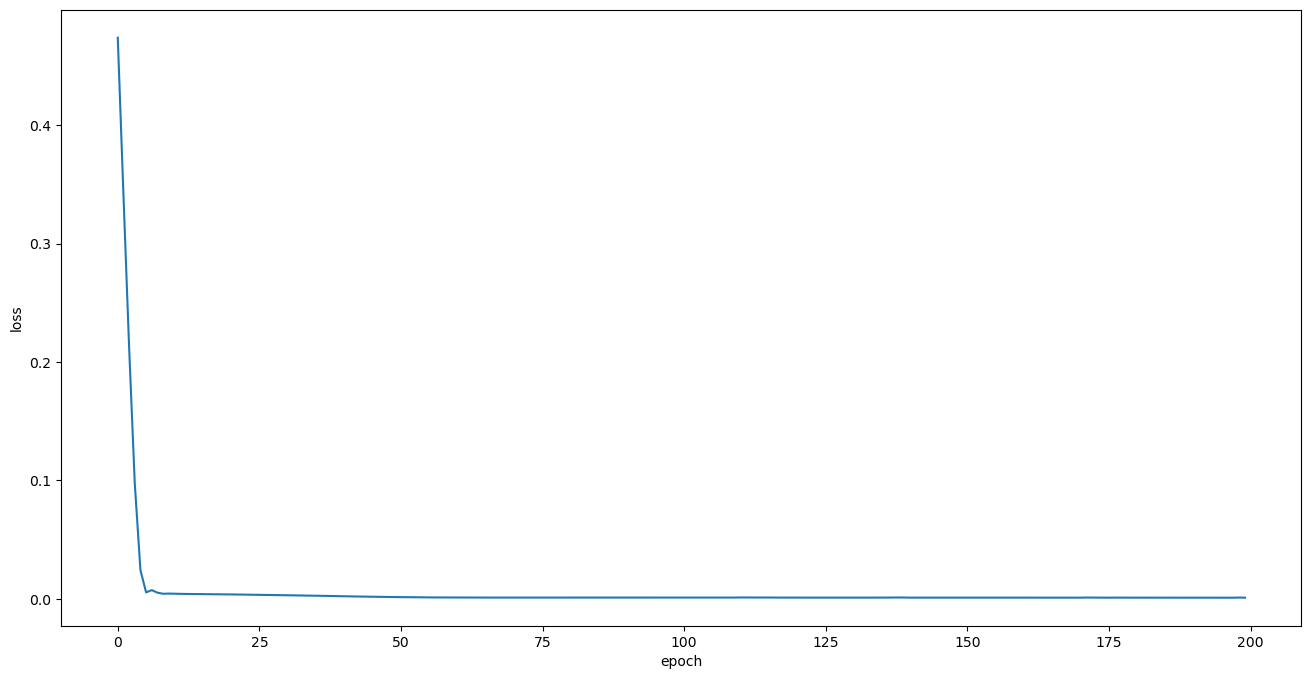

In [34]:
plt.figure(figsize=(16,8))
plt.plot(loss_graph) # epoch 마다 loss를 그려서 모델이 잘 학습됐는지 시각적으로 확인
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

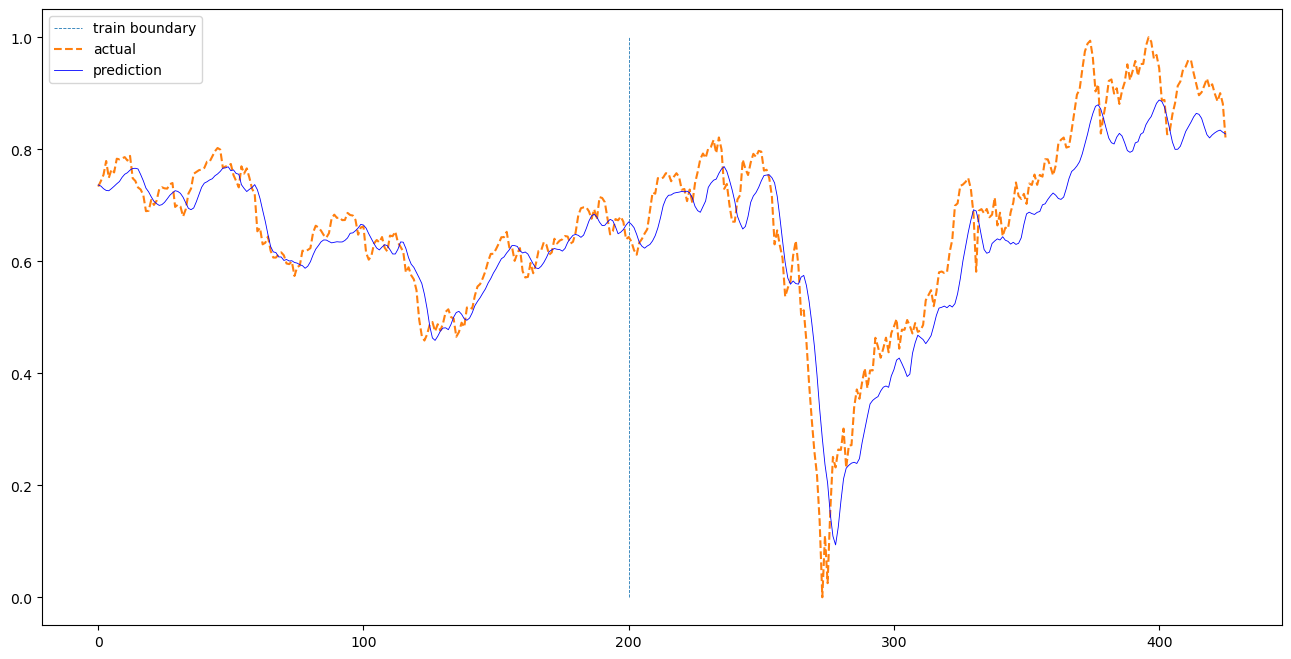

In [35]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad(): # 예측할 때에는 gradient 계산할 필요 없음
        train_pred = []
        test_pred = []
        model.eval()

        for data in train_loader:
            seq, target = data # 배치 데이터
            out = model(seq)
            train_pred += out.cpu().numpy().tolist() 
            # GPU나 MPS같은 가속 장치에서 처리된 텐서를 CPU로 옮겨서 시각화나 결과 저장 등에 사용하기 위해 변환
            # pyTorch에서 텐서를 .numpy()로 변환할 때는 텐서가 반드시 CPU에 있어야한다.
            
        for data in test_loader:
            seq, target = data # 배치 데이터 
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()

    total = train_pred+test_pred    
       
    plt.figure(figsize=(16,8))
    plt.plot(np.ones(100)*len(train_pred),np.linspace(0,1,100),'--', linewidth=0.6)
    plt.plot(actual,'--')
    plt.plot(total,'b', linewidth=0.6)  
    plt.legend(['train boundary','actual','prediction'])
    plt.show() 

train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
plotting(train_loader, test_loader, df['Close'][sequence_length:].values)        

LSTM -> shift 현상이 일어나고 급락하는 구간을 정확히 예측하지는 못했지만 얼추 맞다. 더 정확히 고려하기 위해서는 더 많은 요소를 고려해야 한다. 

GRU -> 급락하는 지점을 더 깊게 예측할 수 있었다. 하지만 여전히 shift 현상이있다. 이럴 경우에 smoothing(선을 좀 더 부드럽게 해주는 작업)처리를 해주거나 1일치만 계산하지 말고 2~3일씩 벡터를 늘려서 계산하면 개선할 수 있다.